start with RunModel_IntervalTracks_to_KDE_16July_HalfDozen_iter3-testing-75epochs-1em4 and replace HalfDozen architecture with HDplus architecture that makes latentChannels output channels at layer 6 and follows that with a convolutional network followed by a single fully connected layer.

as this is the 0-th iteraction, we want to freeze the weights for the first 5 layers that have already been found from the fully connected model.

In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in note"book, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


In [2]:
import numpy as np
##  testing the np.floor and np.int_ methods as they seem to fail in a method used below
##  from model.collectdata_kde_Ellipsoids_29Aug2021 import collect_t2kde_data
print("np.version.version = ",np.version.version)
a = np.array([-1.7, -1.5, -0.2, 0.2, 1.5, 1.7, 2.0])
aFloor = np.floor(a)
print("a = ",a)
print("a.shape = ",a.shape)
print("aFloor = ",aFloor)
print("aFloor.shape = ",aFloor.shape)
aFloorInt = np.int_(aFloor)
print("aFloorInt = ",aFloorInt)

np.version.version =  1.21.2
a =  [-1.7 -1.5 -0.2  0.2  1.5  1.7  2. ]
a.shape =  (7,)
aFloor =  [-2. -2. -1.  0.  1.  1.  2.]
aFloor.shape =  (7,)
aFloorInt =  [-2 -2 -1  0  1  1  2]


This notebook is the second (perhaps third) attempt to read in track information and use it to predict the KDE used as input to pv-finder. This time, we are reading in poca KDEs rather than the original KDEs. 

collectdata_kde_Ellipsoids.py uses poca_z, poca_x, poca_y, and six parameters A, B, C, D, E, and F describing the error ellipsoids are those defined at

from https://math.stackexchange.com/questions/1865188/how-to-prove-the-parallel-projection-of-an-ellipsoid-is-an-ellipse

Up to translation, a general ellipsoid can be written in the form

  𝐴$𝑥^2$ +𝐵$𝑦^2$+𝐶$𝑧^2$+2(𝐷𝑥𝑦+𝐸𝑥𝑧+𝐹𝑦𝑧)=1
  
for some positive-definite coefficient matrix 

$$
\left(\begin{array}{ccc}
A & D & E \\
D & B & F \\
E & F & C \\
\end{array}\right)
$$

Note that other conventions use a similarly named set of parameters with D, E, and and F denoting the coefficients of different combinations of $ x y $, etc., or without the factor of 2 in front of the cross-terms.  However, this is the convention we are using for pv-finder related work, as of early November, 20020


Check the current GPU usage. Please try to be nice!

In [3]:
!nvidia-smi

Sat Jul 30 20:27:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.56       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:18:00.0 Off |                  N/A |
| 29%   28C    P8    21W / 250W |      1MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 29%   

In [4]:
import torch
print(torch.__version__)
print(torch.cuda)

1.8.2+cu111
<module 'torch.cuda' from '/data/home/sokoloff/.local/lib/python3.7/site-packages/torch/cuda/__init__.py'>


> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

This notebook is first attempt to read in track information and use it to predict the KDE used as input to PvFinder.


## Imports

In [5]:
import matplotlib.pyplot as plt
import numpy as np
print("numpy.version.version = ",np.version.version)
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

##from torchsummary import summary

numpy.version.version =  1.21.2


### Set up local parameters

In [6]:
n_epochs = 275

# Name is the output file name


##  201019  mds
folder = '30July_testing_t2hists_HDplusUNet128_iter3_275epochs_5em5'
name   = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)

## batch_size = 64 seems to use 20 GB on 3090,
## so set batch_size = 16 so we can run on a 2080Ti
##  batch_size 16 still seems to require commenting out
##  device=device, and one epoch takes >900 seconds

# Size of batches
batch_size = 64
# How fast to learn
learning_rate = 5e-5

Make the output directory if it does not exist:

In [7]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [8]:
## collectdata_kde_Ellipsoids_29Aug2021 adds zBin and zOffset to X[]
## from model.collectdata_kde_Ellipsoids_29Aug2021 import collect_t2kde_data
##from model.collectdata_kde_Ellipsoids_29Aug2021 import collect_t2kde_data
## revert to traditional collect_t2kde_data
##from model.collectdata_kde_Ellipsoids import collect_t2kde_data
## use July 2022 version of collect_t2kde_data for testing stgructure
## (and later for modifying structure of X[] and Y[])
from model.collectdata_Ellipsoids2Hists_23July2022 import collect_t2hists_data_128bins


## 220714 mds 
## interval_kde_loss_Ba is derived from kde_loss_Ba, modified for 100-bin intervals
## looks like it returns average loss per bin, so costs may be directly
## comparable to original DirtyDozen
from model.alt_loss_AA import Loss

##  
##  This model takes 9 input features (pocca centers + (A,B,C,D,E,F) .
##  TrackIntervalsToKDE_HDplusUNet128 
##  The model has 6 fully connected layers followed by a UNet convolutional process
from model.models_July2022_kde_plus import TrackIntervalsToKDE_HDplusUNet128 as Model


from model.training_kde import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [9]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [10]:
##device = "cuda"
device = select_gpu(2)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 GeForce RTX 3090


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [11]:
##print("Let's use", torch.cuda.device_count(), "GPUs!")
##if torch.cuda.device_count() > 1:
##    model = torch.nn.DataParallel(model)

In [12]:
## a comment on the web at https://pytorch.org/docs/stable/optim.html says
"""
If you need to move a model to GPU via .cuda(), please do so before constructing optimizers for it. 
Parameters of a model after .cuda() will be different objects with those before the call.

In general, you should make sure that optimized parameters live in consistent locations when 
optimizers are constructed and used.
"""
## so move this here (although we are using model.to(device) not explicitly using .cuda()

nOut1 = 20
nOut2 = 20
nOut3 = 20
nOut4 = 20
nOut5 = 20

## Let's try 18 latent channels at the end of the fully connected part of the
## network to "mimic" 3x3 KDE_A and KDE_B feature sets (even though we are NOT
## explicitly building KDEs as inputs to the UNet process)
latentChannels=18

model = Model(nOut1,nOut2,nOut3,nOut4,nOut5,latentChannels)


## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa

## use ct<5 for getting started from HalfDozen model

ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct <5:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
##  loss = Loss(epsilon=1e-5,coefficient=2.5)
##loss = Loss(epsilon=3e-6, debug=False)
loss = Loss(epsilon=1e-5,coefficient=2.5)

ct, child =  0    ConvBNrelu(
  (0): Conv1d(18, 64, kernel_size=(25,), stride=(1,), padding=(12,))
  (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.25, inplace=False)
)
     About to set param.requires_grad=False for ct =  0 params
ct, child =  1    ConvBNrelu(
  (0): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,))
  (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.25, inplace=False)
)
     About to set param.requires_grad=False for ct =  1 params
ct, child =  2    ConvBNrelu(
  (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.25, inplace=False)
)
     About to set param.requires_grad=False for ct =  2 params
ct, child =  3    ConvBNrelu(
  (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,)

Let's move the model's weight matricies to the GPU:

In [13]:
model = model.to(device)

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
##optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [15]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
##    print("value = ", v)
 
updated_dict = model_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE

## comment out reduced biases when "continuing"
##  for a "raw" iter0 (starting from scratch), reduce the initial biases
## updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
## updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
## updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
## updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
## updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]


model.load_state_dict(updated_dict,strict=False)

model_dict = model.state_dict()

output =  ML/30July_testing_t2hists_HDplusUNet128_iter3_275epochs_5em5
for model_dict
index, k =   0    rcbn1.0.weight
index, k =   1    rcbn1.0.bias
index, k =   2    rcbn1.1.weight
index, k =   3    rcbn1.1.bias
index, k =   4    rcbn1.1.running_mean
index, k =   5    rcbn1.1.running_var
index, k =   6    rcbn1.1.num_batches_tracked
index, k =   7    rcbn2.0.weight
index, k =   8    rcbn2.0.bias
index, k =   9    rcbn2.1.weight
index, k =   10    rcbn2.1.bias
index, k =   11    rcbn2.1.running_mean
index, k =   12    rcbn2.1.running_var
index, k =   13    rcbn2.1.num_batches_tracked
index, k =   14    rcbn3.0.weight
index, k =   15    rcbn3.0.bias
index, k =   16    rcbn3.1.weight
index, k =   17    rcbn3.1.bias
index, k =   18    rcbn3.1.running_mean
index, k =   19    rcbn3.1.running_var
index, k =   20    rcbn3.1.num_batches_tracked
index, k =   21    rcbn4.0.weight
index, k =   22    rcbn4.0.bias
index, k =   23    rcbn4.1.weight
index, k =   24    rcbn4.1.bias
index, k =   25   

In [16]:

##print("updated model_dict = ",model_dict)

## print(" \n","  for pretrained_dict")
## index = 0
##for k,v in pretrained_dict.items():
##    print("index, k =  ",index,"  ",k)
##    index = index+1
## mds  

##pretrained_dict = torch.load('ML/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50_final.pyt')
##print("model_dict instantiated")
# 1. filter out unnecessary keys
##pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
##print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
##model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

##model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)


##pretrained_dict = torch.load('ML/27October_testing_DirtyDozen_first_learning_iter0_250epochs_1em3/27October_testing_DirtyDozen_first_learning_iter0_250epochs_1em3_220.pyt')

##  the next model had fluctuations near the end, but the final epoch is within striking distance of the lowest cost
##pretrained_dict = torch.load('ML/06November_testing_DirtyDozen_first_learning_iterB_20epochs_1em6/06November_testing_DirtyDozen_first_learning_iterB_20epochs_1em6_final.pyt')
##pretrained_dict = torch.load('ML/15July_testing_HalfDozen_first_learning_iter0_50epochs_1em4/15July_testing_HalfDozen_first_learning_iter0_50epochs_1em4_49.pyt')
##pretrained_dict = torch.load('ML/16July_testing_HalfDozen_first_learning_iter1_10epochs_1em4/16July_testing_HalfDozen_first_learning_iter1_10epochs_1em4_final.pyt')
##pretrained_dict = torch.load('ML/16July_testing_HalfDozen_first_learning_iter2_50epochs_1em4/16July_testing_HalfDozen_first_learning_iter2_50epochs_1em4_final.pyt')
##pretrained_dict = torch.load('ML/16July_testing_HalfDozen_first_learning_iter3_75epochs_1em4/16July_testing_HalfDozen_first_learning_iter3_75epochs_1em4_final.pyt')
pretrained_dict = torch.load('ML/30July_testing_t2hists_HDplusUNet128_iter2_20epochs_5em5/30July_testing_t2hists_HDplusUNet128_iter2_20epochs_5em5_final.pyt')
print("  for pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
 

##print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)


  for pretrained_dict
index, k =   0    rcbn1.0.weight
index, k =   1    rcbn1.0.bias
index, k =   2    rcbn1.1.weight
index, k =   3    rcbn1.1.bias
index, k =   4    rcbn1.1.running_mean
index, k =   5    rcbn1.1.running_var
index, k =   6    rcbn1.1.num_batches_tracked
index, k =   7    rcbn2.0.weight
index, k =   8    rcbn2.0.bias
index, k =   9    rcbn2.1.weight
index, k =   10    rcbn2.1.bias
index, k =   11    rcbn2.1.running_mean
index, k =   12    rcbn2.1.running_var
index, k =   13    rcbn2.1.num_batches_tracked
index, k =   14    rcbn3.0.weight
index, k =   15    rcbn3.0.bias
index, k =   16    rcbn3.1.weight
index, k =   17    rcbn3.1.bias
index, k =   18    rcbn3.1.running_mean
index, k =   19    rcbn3.1.running_var
index, k =   20    rcbn3.1.num_batches_tracked
index, k =   21    rcbn4.0.weight
index, k =   22    rcbn4.0.bias
index, k =   23    rcbn4.1.weight
index, k =   24    rcbn4.1.bias
index, k =   25    rcbn4.1.running_mean
index, k =   26    rcbn4.1.running_var
ind

<All keys matched successfully>

##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

Loading data...
  
targetHist.shape =       (20000, 4000)
binsPerInterval =  128
nIntervals =        31
nBins =  4000
binsPerInteral*nIntervals =  3968
intervalHists.shape =  (620000, 128)
Y_intervals.shape   =  (620000, 128)
pocaMx.shape =  (20000,)
nEvts =  20000
pocaz.shape =  (20000,)
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
 *** intervalLength in mm =  12.903225806451612    ***
eventIndex =  0
len(X_ints) = 620000
len(Xlist_ints) =  1
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 49.3 s
Constructing 570000 event dataset took 0.3343 s
x_t_intervals.shape =  torch.Size([570000, 9, 150])
x_t_intervals.shape[0] =  570000
x_t_intervals.shape[1] =

<IPython.core.display.Javascript object>


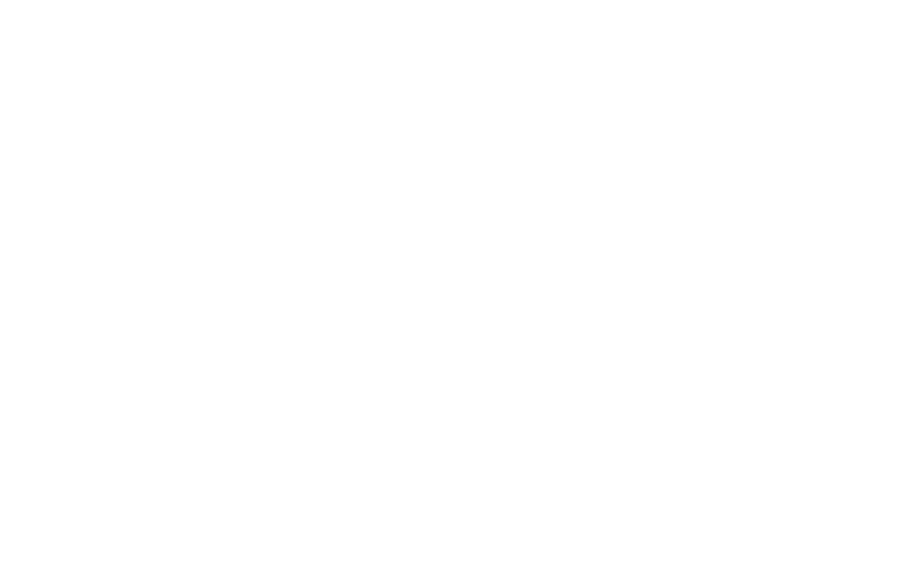

<IPython.core.display.Javascript object>


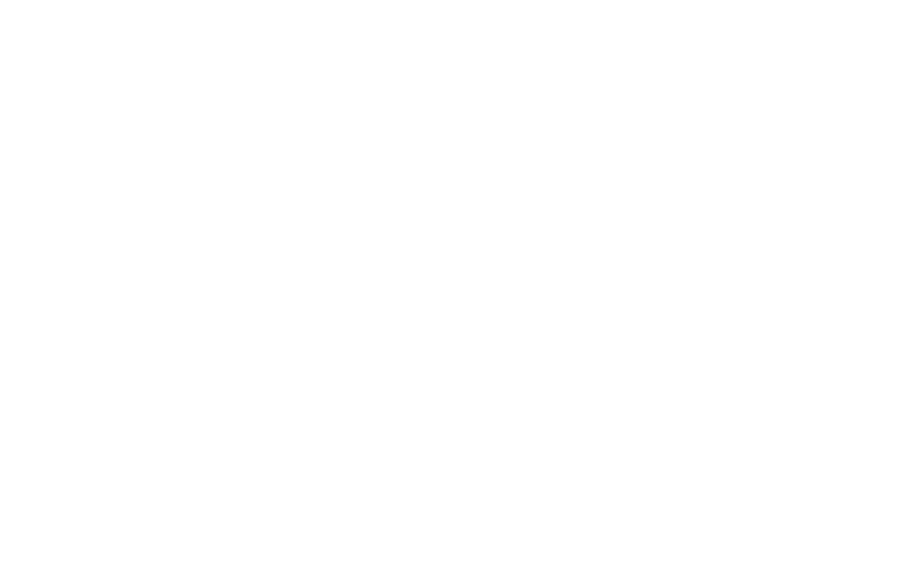

<IPython.core.display.Javascript object>


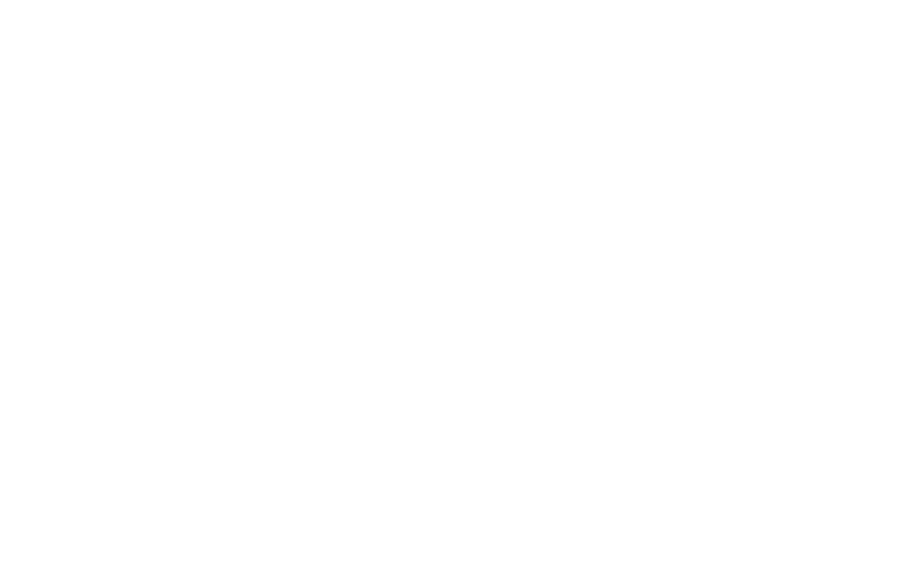

<IPython.core.display.Javascript object>


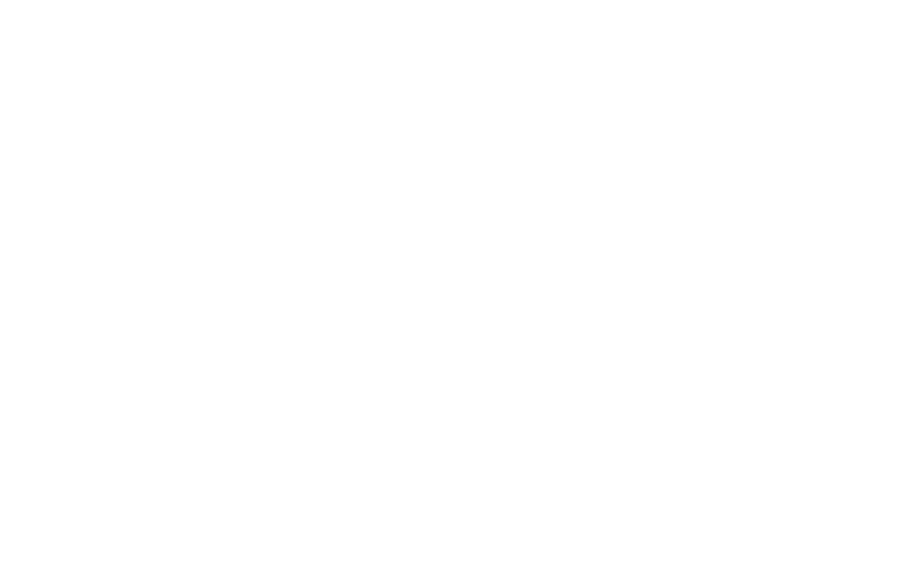

<IPython.core.display.Javascript object>


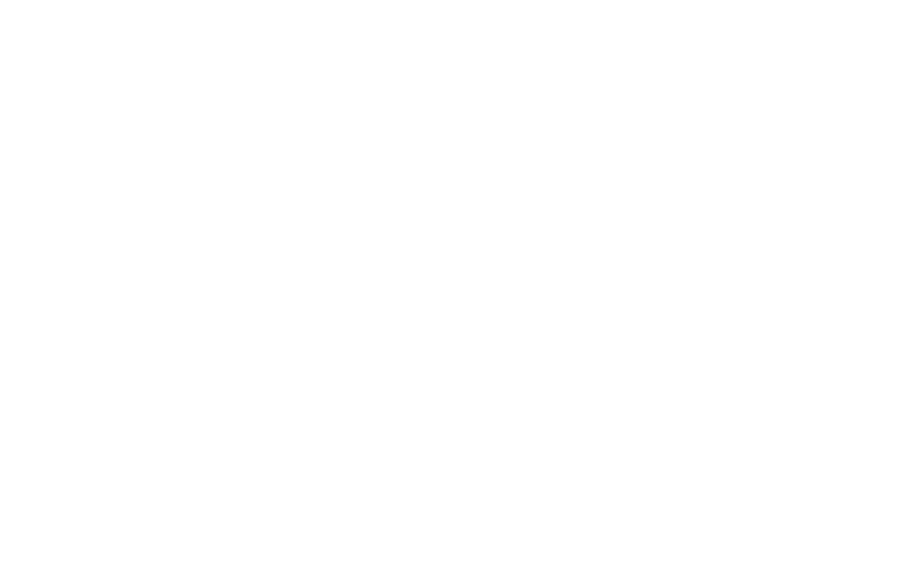

<IPython.core.display.Javascript object>


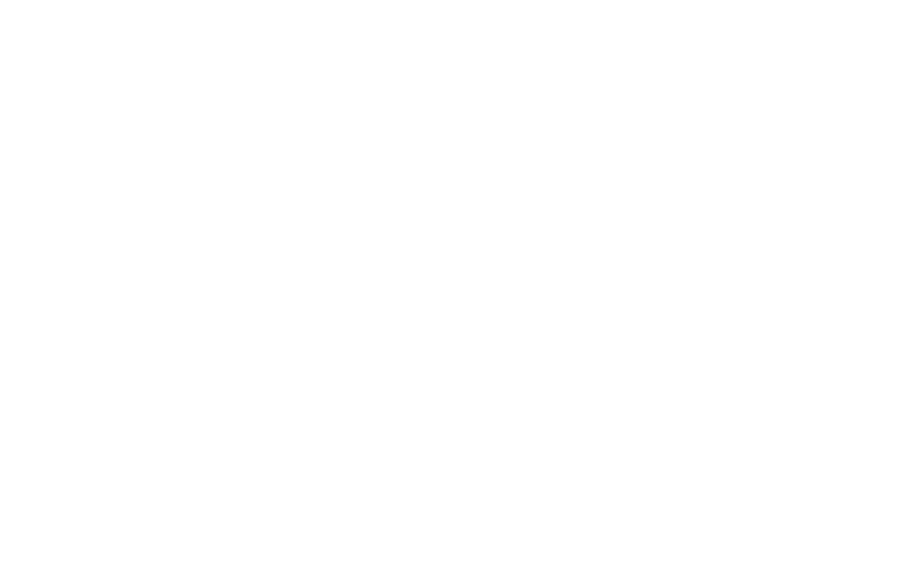

<IPython.core.display.Javascript object>


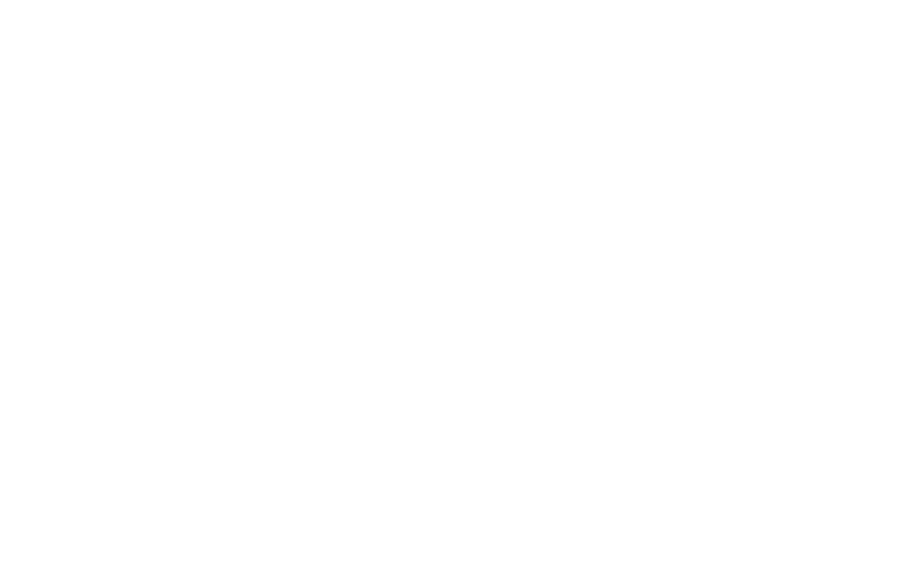

Loading data...
  
targetHist.shape =       (20000, 4000)
binsPerInterval =  128
nIntervals =        31
nBins =  4000
binsPerInteral*nIntervals =  3968
intervalHists.shape =  (620000, 128)
Y_intervals.shape   =  (620000, 128)
pocaMx.shape =  (20000,)
nEvts =  20000
pocaz.shape =  (20000,)
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
 *** intervalLength in mm =  12.903225806451612    ***
eventIndex =  0
len(X_ints) = 620000
len(Xlist_ints) =  1
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 50.67 s
Constructing 50000 event dataset took 0.0444 s
x_t_intervals.shape =  torch.Size([50000, 9, 150])
x_t_intervals.shape[0] =  50000
x_t_intervals.shape[1] =  

<IPython.core.display.Javascript object>


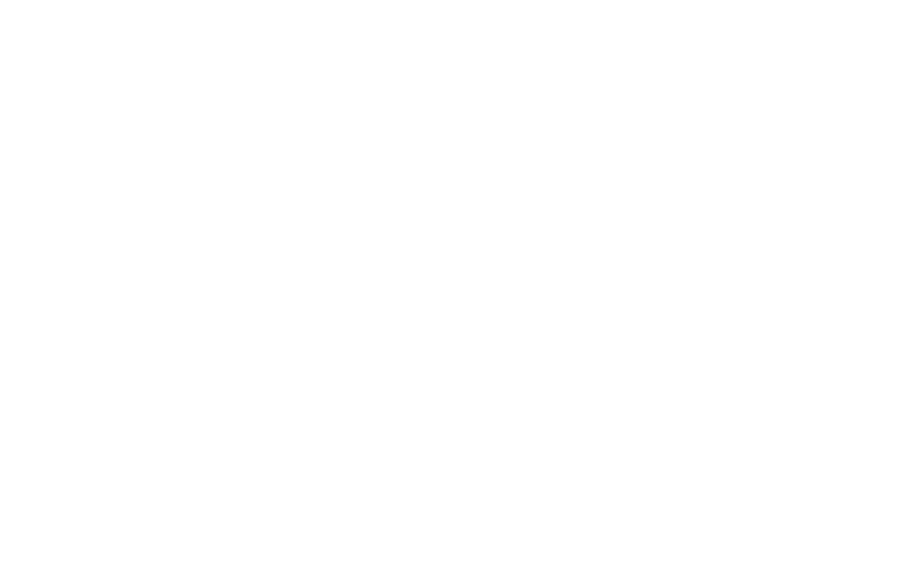

<IPython.core.display.Javascript object>


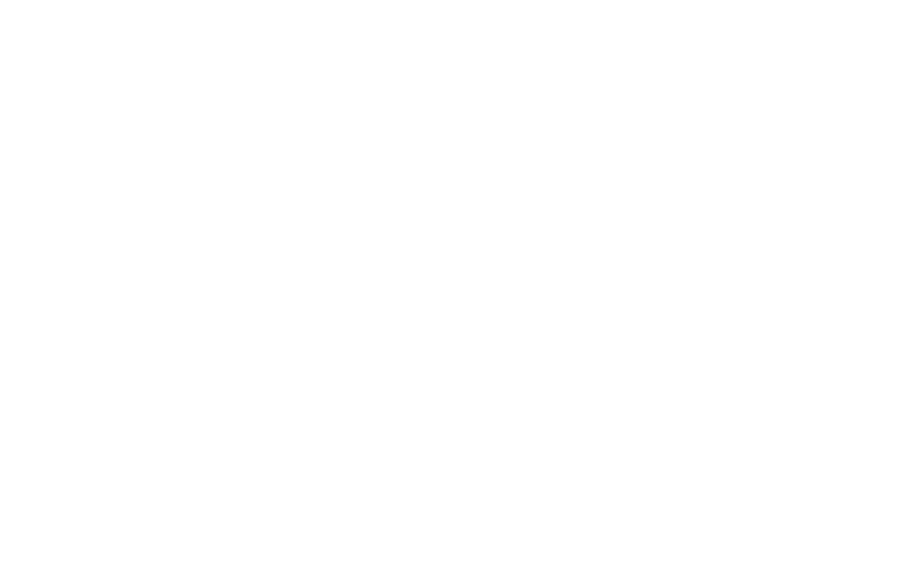

<IPython.core.display.Javascript object>


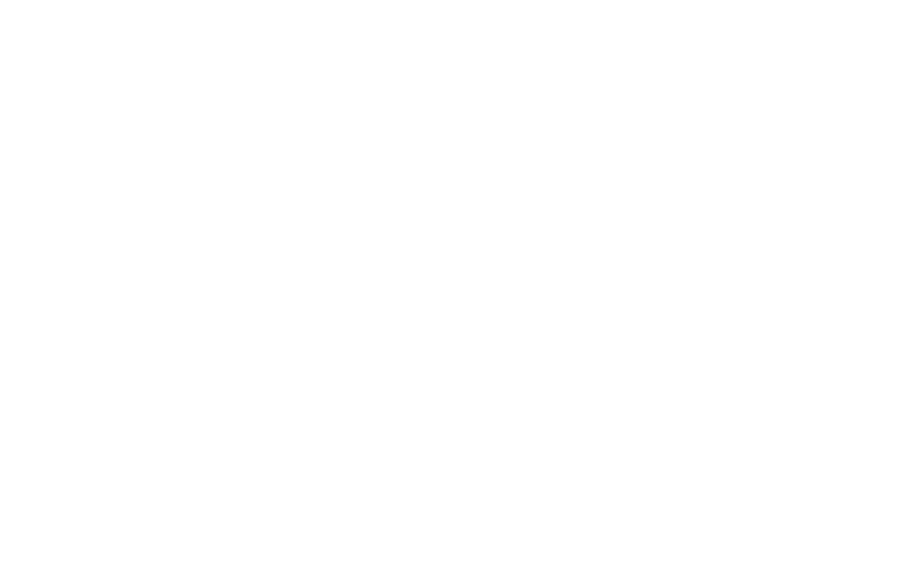

<IPython.core.display.Javascript object>


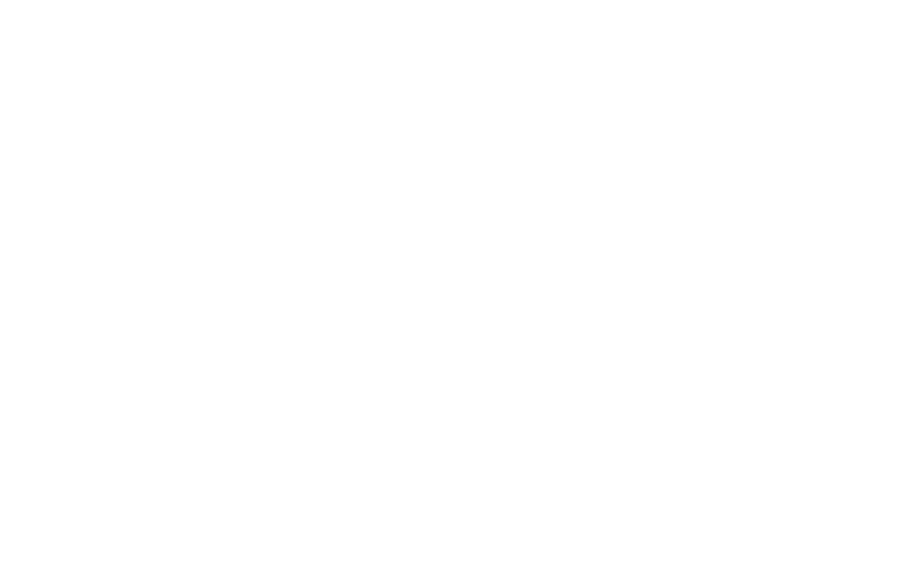

<IPython.core.display.Javascript object>


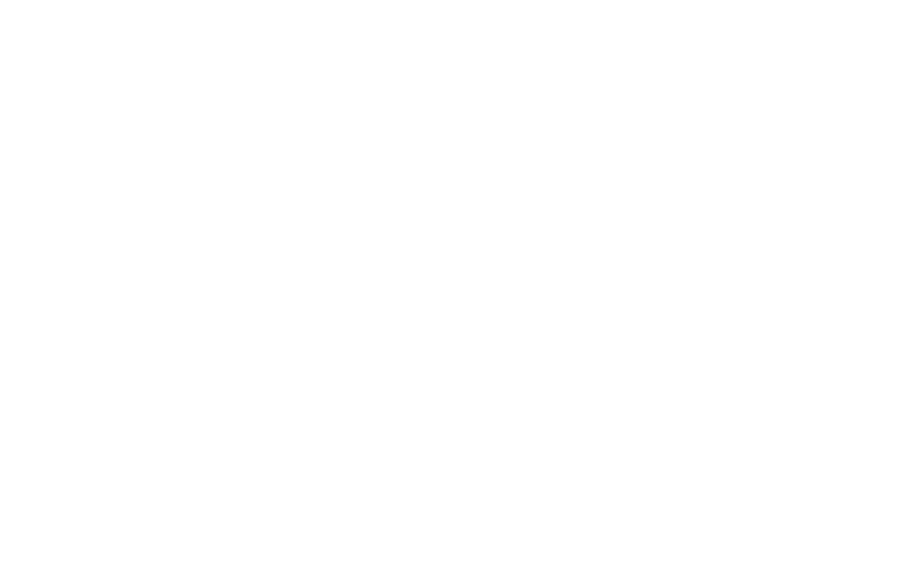

<IPython.core.display.Javascript object>


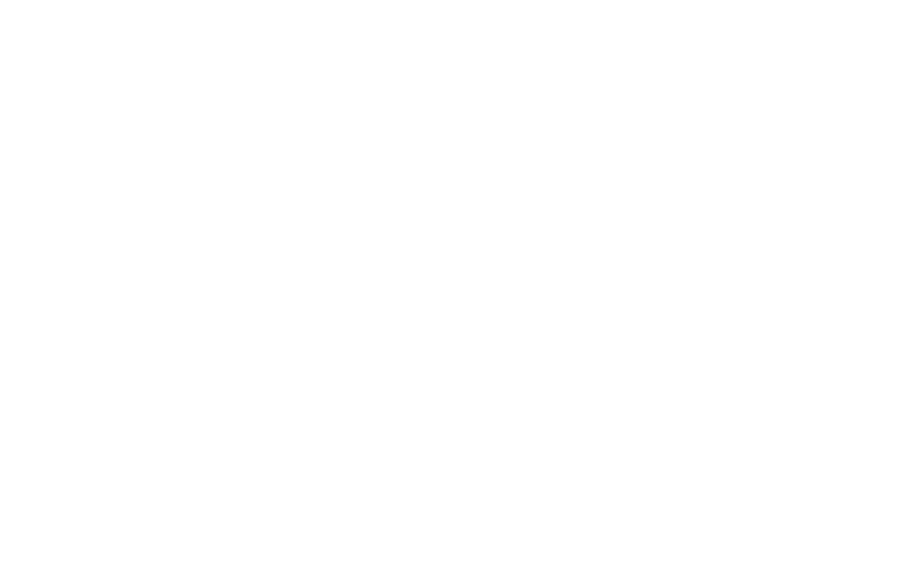

<IPython.core.display.Javascript object>


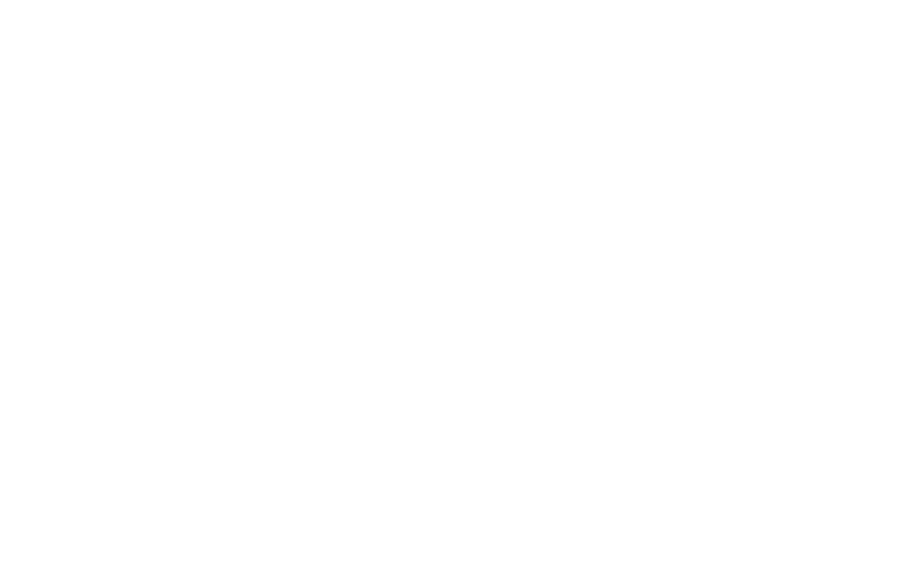

In [17]:
## Training dataset. You can put as many files here as desired.

##train_loader = collect_t2kde_data('/share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5',
train_loader = collect_t2hists_data_128bins('dataAA/20K_POCA_kernel_evts_200926.h5',
##train_loader = collect_t2kde_data('/share/lazy/sokoloff/ML-data_AA/100_POCA_kernel_evts_210829.h5',                                  
##train_loader = collect_t2kde_data('/share/lazy/pv-finder/test_data_for_KDE_learning_BastilleDay20.h5',
                            batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                                  
## 220715 running out of CUDA memory when device=device enabled,
## so comment out to see if this helps
## remove commenting out 220716 as I will try to use the 3090
##                          device=device,
##  slice is used as index in feature set defined in terms of intervals
##  and there are 620K intervals of 128 bins in a file with 20K events
                           slice = slice(None,570000)
                           )
                            

# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2hists_data_128bins('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
## 220715 running out of CUDA memory when device=device enabled,
## so comment out to see if this helps
##                          device=device,
                            slice = slice(570000,None)
                           )

with torch.no_grad():
    counter = 0
    event = 0
    print("train_loader = ",train_loader)
    for inputs, labels in train_loader:
##        print("counter = ",counter)
##        print("inputs = ",inputs)
        print("inputs.shape = ",inputs.shape)
        if inputs.device != device:
            inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = model(inputs)
##        print("outputs.shape = ",outputs.shape)
        nEvts = outputs.shape[0]
        for iEvt in range(nEvts):
            y_pred = outputs[iEvt,:]
            y_pred = y_pred.cpu().numpy()
            
            event = event +1
##            print("event = ",event)
            if (event<5):
                plt.figure()
                plt.plot(y_pred[0:50])
                plt.show()
                
##                print("  point AA ")
                features = inputs[iEvt,:]
                features = features[np.newaxis,:,:]
                
                
                print("features.shape = ",features.shape)
                
                output_A = model(features)
                y_prime = output_A[0,:]
                y_prime = y_prime.cpu().numpy()
                plt.figure()
                plt.plot(y_prime[0:50], color="r")
                plt.show()
                
            

##        print("nEvts = ",nEvts)
        
        counter = counter+1
        
        
        

<IPython.core.display.Javascript object>


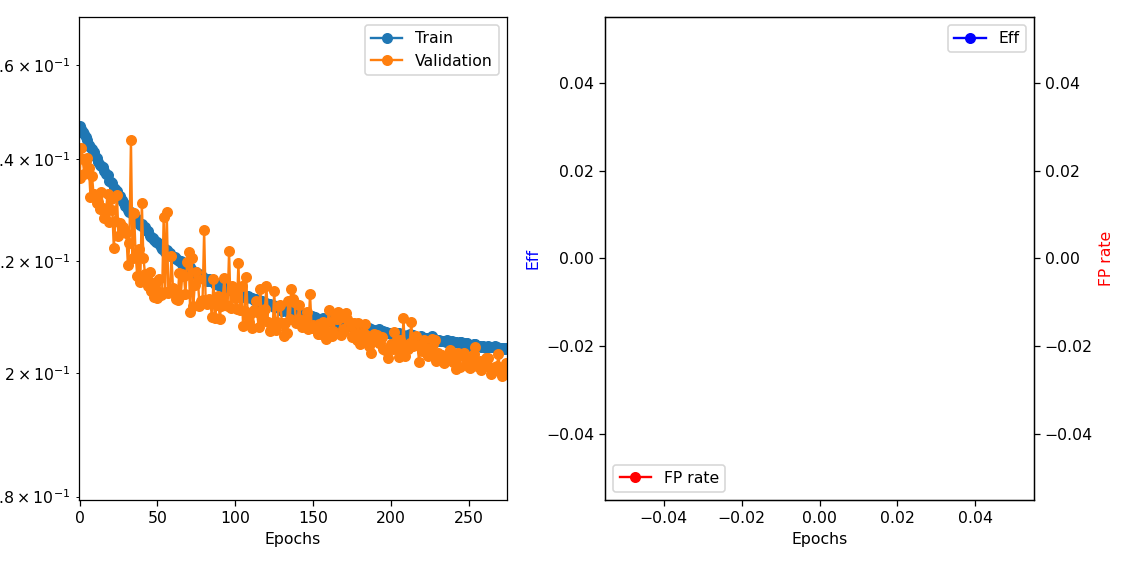

In [18]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [19]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 8907, val = 782


Number of batches: train = 8907, val = 782


Epoch 0: train=0.246734, val=0.236125, took 131.78 s


Epoch 1: train=0.246245, val=0.242221, took 131.57 s


Epoch 2: train=0.245587, val=0.239946, took 134.48 s


Epoch 3: train=0.245201, val=0.237026, took 130.97 s


Epoch 4: train=0.244605, val=0.239512, took 133.44 s


Epoch 5: train=0.243949, val=0.240094, took 135.0 s


Epoch 6: train=0.242853, val=0.238256, took 132.9 s


Epoch 7: train=0.242497, val=0.232439, took 130.76 s


Epoch 8: train=0.242003, val=0.236595, took 134.39 s


Epoch 9: train=0.241348, val=0.232858, took 130.0 s


Epoch 10: train=0.240532, val=0.232321, took 133.79 s


Epoch 11: train=0.240289, val=0.231136, took 135.85 s


Epoch 12: train=0.23935, val=0.23126, took 134.12 s


Epoch 13: train=0.238686, val=0.230048, took 137.06 s


Epoch 14: train=0.238626, val=0.233323, took 130.84 s


Epoch 15: train=0.238379, val=0.230103, took 132.01 s


Epoch 16: train=0.237482, val=0.228234, took 130.7 s


Epoch 17: train=0.236903, val=0.22975, took 131.99 s


Epoch 18: train=0.236798, val=0.233014, took 133.78 s


Epoch 19: train=0.235508, val=0.227425, took 134.42 s


Epoch 20: train=0.235358, val=0.231897, took 132.48 s


Epoch 21: train=0.235115, val=0.229844, took 130.1 s


Epoch 22: train=0.234148, val=0.222376, took 129.91 s


Epoch 23: train=0.233926, val=0.227561, took 133.31 s


Epoch 24: train=0.233573, val=0.232711, took 133.51 s


Epoch 25: train=0.2327, val=0.224826, took 134.1 s


Epoch 26: train=0.232504, val=0.22721, took 123.22 s


Epoch 27: train=0.231711, val=0.226104, took 117.63 s


Epoch 28: train=0.231389, val=0.226543, took 131.3 s


Epoch 29: train=0.230504, val=0.225457, took 125.47 s


Epoch 30: train=0.23069, val=0.225384, took 118.8 s


Epoch 31: train=0.229737, val=0.219338, took 113.32 s


Epoch 32: train=0.229387, val=0.223326, took 124.8 s


Epoch 33: train=0.2293, val=0.243942, took 124.54 s


Epoch 34: train=0.228881, val=0.220668, took 124.61 s


Epoch 35: train=0.228852, val=0.22923, took 118.55 s


Epoch 36: train=0.228141, val=0.221337, took 121.45 s


Epoch 37: train=0.227369, val=0.217289, took 119.39 s


Epoch 38: train=0.227278, val=0.222319, took 118.7 s


Epoch 39: train=0.226887, val=0.216069, took 124.31 s


Epoch 40: train=0.226974, val=0.231169, took 118.56 s


Epoch 41: train=0.226397, val=0.220626, took 117.53 s


Epoch 42: train=0.226483, val=0.217682, took 113.39 s


Epoch 43: train=0.225721, val=0.21687, took 123.72 s


Epoch 44: train=0.225735, val=0.21536, took 118.8 s


Epoch 45: train=0.22473, val=0.218002, took 125.6 s


Epoch 46: train=0.224582, val=0.214461, took 120.41 s


Epoch 47: train=0.224427, val=0.215922, took 126.13 s


Epoch 48: train=0.224055, val=0.213428, took 123.34 s


Epoch 49: train=0.223638, val=0.216036, took 126.04 s


Epoch 50: train=0.223577, val=0.213219, took 138.89 s


Epoch 51: train=0.223312, val=0.216737, took 122.95 s


Epoch 52: train=0.222706, val=0.21366, took 115.23 s


Epoch 53: train=0.22236, val=0.21394, took 124.84 s


Epoch 54: train=0.222429, val=0.228348, took 121.33 s


Epoch 55: train=0.221748, val=0.214227, took 121.19 s


Epoch 56: train=0.222022, val=0.229394, took 116.52 s


Epoch 57: train=0.221747, val=0.214154, took 125.91 s


Epoch 58: train=0.22143, val=0.214392, took 114.02 s


Epoch 59: train=0.220936, val=0.221041, took 123.52 s


Epoch 60: train=0.220722, val=0.214935, took 117.69 s


Epoch 61: train=0.220698, val=0.214224, took 126.3 s


Epoch 62: train=0.220313, val=0.213068, took 118.39 s


Epoch 63: train=0.220255, val=0.212855, took 123.08 s


Epoch 64: train=0.220039, val=0.217807, took 113.6 s


Epoch 65: train=0.219944, val=0.213688, took 122.83 s


Epoch 66: train=0.21951, val=0.217545, took 118.35 s


Epoch 67: train=0.219302, val=0.217198, took 127.76 s


Epoch 68: train=0.219654, val=0.21386, took 122.53 s


Epoch 69: train=0.218866, val=0.219767, took 127.62 s


Epoch 70: train=0.218891, val=0.221716, took 126.03 s


Epoch 71: train=0.21882, val=0.210648, took 119.94 s


Epoch 72: train=0.218269, val=0.220637, took 125.01 s


Epoch 73: train=0.21789, val=0.211706, took 124.47 s


Epoch 74: train=0.217684, val=0.215522, took 116.93 s


Epoch 75: train=0.217949, val=0.218038, took 126.83 s


Epoch 76: train=0.217641, val=0.216666, took 117.35 s


Epoch 77: train=0.217672, val=0.211698, took 117.58 s


Epoch 78: train=0.217363, val=0.212608, took 119.89 s


Epoch 79: train=0.217036, val=0.212887, took 123.03 s


Epoch 80: train=0.216721, val=0.225925, took 123.04 s


Epoch 81: train=0.2167, val=0.212247, took 123.9 s


Epoch 82: train=0.216355, val=0.212039, took 119.51 s


Epoch 83: train=0.21658, val=0.213086, took 115.29 s


Epoch 84: train=0.216212, val=0.212353, took 123.03 s


Epoch 85: train=0.21646, val=0.209715, took 118.59 s


Epoch 86: train=0.21623, val=0.216721, took 119.39 s


Epoch 87: train=0.215721, val=0.209523, took 114.62 s


Epoch 88: train=0.215764, val=0.211883, took 122.79 s


Epoch 89: train=0.215574, val=0.213614, took 129.46 s


Epoch 90: train=0.215888, val=0.209495, took 117.87 s


Epoch 91: train=0.215296, val=0.211764, took 114.19 s


Epoch 92: train=0.215587, val=0.213355, took 114.56 s


Epoch 93: train=0.215052, val=0.216917, took 116.84 s


Epoch 94: train=0.214987, val=0.211947, took 117.34 s


Epoch 95: train=0.214953, val=0.211666, took 114.85 s


Epoch 96: train=0.21469, val=0.22188, took 119.12 s


Epoch 97: train=0.214607, val=0.211423, took 125.2 s


Epoch 98: train=0.21458, val=0.215427, took 121.69 s


Epoch 99: train=0.214322, val=0.214185, took 126.13 s


Epoch 100: train=0.214645, val=0.213234, took 121.4 s


Epoch 101: train=0.214201, val=0.211199, took 124.23 s


Epoch 102: train=0.214092, val=0.219683, took 118.82 s


Epoch 103: train=0.213786, val=0.210996, took 113.73 s


Epoch 104: train=0.213669, val=0.215454, took 124.83 s


Epoch 105: train=0.213748, val=0.208187, took 119.7 s


Epoch 106: train=0.213423, val=0.210839, took 127.26 s


Epoch 107: train=0.213152, val=0.217062, took 119.04 s


Epoch 108: train=0.213493, val=0.209885, took 114.03 s


Epoch 109: train=0.213306, val=0.208918, took 122.24 s


Epoch 110: train=0.213273, val=0.210461, took 120.04 s


Epoch 111: train=0.213152, val=0.2078, took 122.84 s


Epoch 112: train=0.212752, val=0.210934, took 126.19 s


Epoch 113: train=0.212928, val=0.212638, took 119.19 s


Epoch 114: train=0.21255, val=0.210615, took 113.05 s


Epoch 115: train=0.212885, val=0.208014, took 124.29 s


Epoch 116: train=0.212341, val=0.214826, took 121.31 s


Epoch 117: train=0.212678, val=0.209399, took 118.4 s


Epoch 118: train=0.212277, val=0.21048, took 121.68 s


Epoch 119: train=0.21222, val=0.211162, took 121.61 s


Epoch 120: train=0.212321, val=0.215349, took 114.28 s


Epoch 121: train=0.212016, val=0.208854, took 123.03 s


Epoch 122: train=0.212123, val=0.207254, took 122.76 s


Epoch 123: train=0.211935, val=0.207505, took 124.81 s


Epoch 124: train=0.211899, val=0.207666, took 118.91 s


Epoch 125: train=0.211544, val=0.214489, took 127.32 s


Epoch 126: train=0.211585, val=0.20753, took 120.77 s


Epoch 127: train=0.21152, val=0.208898, took 120.94 s


Epoch 128: train=0.211527, val=0.211818, took 122.55 s


Epoch 129: train=0.21126, val=0.211884, took 126.41 s


Epoch 130: train=0.210878, val=0.208623, took 122.49 s


Epoch 131: train=0.21163, val=0.206469, took 124.22 s


Epoch 132: train=0.211337, val=0.208652, took 123.8 s


Epoch 133: train=0.210886, val=0.206913, took 122.27 s


Epoch 134: train=0.210686, val=0.212574, took 121.88 s


Epoch 135: train=0.211082, val=0.2094, took 121.3 s


Epoch 136: train=0.210727, val=0.21489, took 123.0 s


Epoch 137: train=0.210573, val=0.212954, took 121.78 s


Epoch 138: train=0.210419, val=0.212423, took 121.78 s


Epoch 139: train=0.210469, val=0.208617, took 121.08 s


Epoch 140: train=0.210396, val=0.209342, took 120.44 s


Epoch 141: train=0.210193, val=0.211868, took 122.56 s


Epoch 142: train=0.210152, val=0.209246, took 122.33 s


Epoch 143: train=0.210252, val=0.20797, took 121.28 s


Epoch 144: train=0.210097, val=0.209222, took 122.11 s


Epoch 145: train=0.210282, val=0.209109, took 123.86 s


Epoch 146: train=0.209901, val=0.210596, took 126.58 s


Epoch 147: train=0.209603, val=0.207656, took 121.23 s


Epoch 148: train=0.209882, val=0.213998, took 121.11 s


Epoch 149: train=0.209909, val=0.20785, took 120.2 s


Epoch 150: train=0.209758, val=0.208312, took 124.51 s


Epoch 151: train=0.20971, val=0.208057, took 120.61 s


Epoch 152: train=0.209628, val=0.20793, took 121.03 s


Epoch 153: train=0.209482, val=0.206753, took 122.83 s


Epoch 154: train=0.209265, val=0.208555, took 120.96 s


Epoch 155: train=0.209454, val=0.206809, took 122.48 s


Epoch 156: train=0.209507, val=0.208783, took 122.1 s


Epoch 157: train=0.209196, val=0.208528, took 121.1 s


Epoch 158: train=0.20918, val=0.205811, took 120.12 s


Epoch 159: train=0.209229, val=0.207084, took 121.84 s


Epoch 160: train=0.20931, val=0.210974, took 119.83 s


Epoch 161: train=0.209019, val=0.208924, took 122.17 s


Epoch 162: train=0.209066, val=0.206448, took 120.92 s


Epoch 163: train=0.208821, val=0.207306, took 120.29 s


Epoch 164: train=0.208797, val=0.20967, took 121.31 s


Epoch 165: train=0.208679, val=0.209444, took 123.73 s


Epoch 166: train=0.208166, val=0.210723, took 123.09 s


Epoch 167: train=0.208561, val=0.209603, took 121.44 s


Epoch 168: train=0.208737, val=0.206574, took 122.64 s


Epoch 169: train=0.208573, val=0.207589, took 119.9 s


Epoch 170: train=0.208603, val=0.207211, took 121.38 s


Epoch 171: train=0.2085, val=0.210438, took 122.28 s


Epoch 172: train=0.208568, val=0.209461, took 122.4 s


Epoch 173: train=0.208121, val=0.208834, took 121.42 s


Epoch 174: train=0.208487, val=0.208187, took 121.98 s


Epoch 175: train=0.208236, val=0.206149, took 120.36 s


Epoch 176: train=0.208135, val=0.208741, took 120.88 s


Epoch 177: train=0.20829, val=0.207009, took 120.37 s


Epoch 178: train=0.207976, val=0.205706, took 120.19 s


Epoch 179: train=0.208054, val=0.208729, took 121.3 s


Epoch 180: train=0.207601, val=0.204972, took 120.64 s


Epoch 181: train=0.207743, val=0.206458, took 121.11 s


Epoch 182: train=0.20768, val=0.207134, took 120.79 s


Epoch 183: train=0.207779, val=0.208429, took 123.48 s


Epoch 184: train=0.207758, val=0.206515, took 121.03 s


Epoch 185: train=0.207882, val=0.205106, took 123.49 s


Epoch 186: train=0.20776, val=0.204623, took 121.01 s


Epoch 187: train=0.207557, val=0.20351, took 120.73 s


Epoch 188: train=0.207174, val=0.205655, took 120.87 s


Epoch 189: train=0.207448, val=0.206716, took 120.94 s


Epoch 190: train=0.207237, val=0.205436, took 121.43 s


Epoch 191: train=0.207233, val=0.206502, took 123.29 s


Epoch 192: train=0.207601, val=0.205174, took 121.26 s


Epoch 193: train=0.207205, val=0.20521, took 120.56 s


Epoch 194: train=0.207128, val=0.20617, took 121.19 s


Epoch 195: train=0.2072, val=0.204085, took 121.33 s


Epoch 196: train=0.207157, val=0.203995, took 122.83 s


Epoch 197: train=0.207103, val=0.203955, took 121.82 s


Epoch 198: train=0.206954, val=0.202594, took 125.41 s


Epoch 199: train=0.206863, val=0.204165, took 121.37 s


Epoch 200: train=0.206663, val=0.205014, took 122.91 s


Epoch 201: train=0.206715, val=0.204136, took 122.16 s


Epoch 202: train=0.206376, val=0.207048, took 122.12 s


Epoch 203: train=0.206923, val=0.204988, took 122.35 s


Epoch 204: train=0.206446, val=0.20576, took 121.57 s


Epoch 205: train=0.206884, val=0.202745, took 122.1 s


Epoch 206: train=0.20651, val=0.205677, took 121.78 s


Epoch 207: train=0.206359, val=0.203065, took 123.8 s


Epoch 208: train=0.206658, val=0.209665, took 121.73 s


Epoch 209: train=0.206388, val=0.20285, took 123.21 s


Epoch 210: train=0.206411, val=0.204871, took 125.24 s


Epoch 211: train=0.20655, val=0.204123, took 123.84 s


Epoch 212: train=0.206781, val=0.205189, took 123.54 s


Epoch 213: train=0.206383, val=0.208804, took 124.27 s


Epoch 214: train=0.206533, val=0.204573, took 124.93 s


Epoch 215: train=0.206131, val=0.205213, took 123.83 s


Epoch 216: train=0.206262, val=0.206343, took 123.43 s


Epoch 217: train=0.206156, val=0.204791, took 123.25 s


Epoch 218: train=0.206248, val=0.201959, took 123.85 s


Epoch 219: train=0.206421, val=0.204824, took 124.17 s


Epoch 220: train=0.205823, val=0.203688, took 122.4 s


Epoch 221: train=0.206111, val=0.205673, took 123.99 s


Epoch 222: train=0.206, val=0.20437, took 123.88 s


Epoch 223: train=0.206018, val=0.203322, took 122.76 s


Epoch 224: train=0.2061, val=0.202889, took 120.66 s


Epoch 225: train=0.206017, val=0.203534, took 123.46 s


Epoch 226: train=0.206376, val=0.205934, took 124.78 s


Epoch 227: train=0.205995, val=0.205011, took 124.06 s


Epoch 228: train=0.205369, val=0.20564, took 124.37 s


Epoch 229: train=0.205619, val=0.202126, took 124.34 s


Epoch 230: train=0.205523, val=0.203493, took 122.58 s


Epoch 231: train=0.205704, val=0.20238, took 122.7 s


Epoch 232: train=0.205448, val=0.202929, took 123.38 s


Epoch 233: train=0.20547, val=0.203001, took 123.92 s


Epoch 234: train=0.205537, val=0.201768, took 121.1 s


Epoch 235: train=0.205295, val=0.202566, took 123.73 s


Epoch 236: train=0.205647, val=0.202639, took 121.02 s


Epoch 237: train=0.205514, val=0.202485, took 121.66 s


Epoch 238: train=0.205183, val=0.203896, took 125.45 s


Epoch 239: train=0.205585, val=0.202625, took 124.33 s


Epoch 240: train=0.205103, val=0.201813, took 126.49 s


Epoch 241: train=0.205319, val=0.201904, took 123.43 s


Epoch 242: train=0.205396, val=0.200732, took 123.96 s


Epoch 243: train=0.205163, val=0.203416, took 119.94 s


Epoch 244: train=0.2053, val=0.201058, took 123.6 s


Epoch 245: train=0.205361, val=0.203058, took 122.58 s


Epoch 246: train=0.20499, val=0.202936, took 123.24 s


Epoch 247: train=0.205222, val=0.203406, took 123.05 s


Epoch 248: train=0.205126, val=0.202316, took 124.33 s


Epoch 249: train=0.205168, val=0.202282, took 123.36 s


Epoch 250: train=0.204719, val=0.200938, took 124.24 s


Epoch 251: train=0.2049, val=0.20093, took 125.26 s


Epoch 252: train=0.204801, val=0.201817, took 124.32 s


Epoch 253: train=0.20491, val=0.203192, took 123.89 s


Epoch 254: train=0.204972, val=0.204387, took 123.74 s


Epoch 255: train=0.20472, val=0.201157, took 123.49 s


Epoch 256: train=0.204633, val=0.20119, took 122.62 s


Epoch 257: train=0.204609, val=0.202018, took 123.1 s


Epoch 258: train=0.204502, val=0.200517, took 124.55 s


Epoch 259: train=0.204646, val=0.201703, took 122.43 s


Epoch 260: train=0.204554, val=0.201188, took 123.82 s


Epoch 261: train=0.204252, val=0.202596, took 123.62 s


Epoch 262: train=0.20461, val=0.202611, took 123.34 s


Epoch 263: train=0.204536, val=0.200936, took 123.1 s


Epoch 264: train=0.204555, val=0.199788, took 123.5 s


Epoch 265: train=0.204481, val=0.200553, took 125.87 s


Epoch 266: train=0.20452, val=0.200783, took 125.92 s


Epoch 267: train=0.2046, val=0.200981, took 123.84 s


Epoch 268: train=0.204406, val=0.201119, took 123.99 s


Epoch 269: train=0.204134, val=0.20317, took 123.48 s


Epoch 270: train=0.204289, val=0.200202, took 124.53 s


Epoch 271: train=0.204353, val=0.199418, took 123.13 s


Epoch 272: train=0.204267, val=0.199891, took 122.58 s


Epoch 273: train=0.204176, val=0.200654, took 123.76 s


Epoch 274: train=0.2043, val=0.201726, took 125.38 s



Go ahead and save the final model (even though it was also saved above):

In [20]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [21]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

Save the plot above:

In [22]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

<IPython.core.display.Javascript object>

In [24]:
##quit()
